<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Total epochs = 100, batch_size = 16
# T1 = 2700, T2 = 300, T3 = 12,000
# 1st 18 epochs, train generator only using MSE loss. next 2 epochs, train only discriminator using discriminator loss
# Remaining 80 epochs, train both using generator and discriminator loss
# Increase training set to 600 images, test set to 30 images and reduce percent mask to 50%, 

import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Conv2DTranspose, Flatten, Dense
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
# Google Drive API Code to authenticate access to your google acount drive that has the dataset in it
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
# images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
# dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
data_key = '1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g'

image_data = load_drive_data(data_key)
images = dict_to_array(image_data)

# # Create data copy to local storage, can be accessed directly from there
with open('image_data.pickle', 'wb') as file:
    joblib.dump(images, file)

# Load the test set images required
# with open('/content/image_data.pickle', 'rb') as file:
#     images = joblib.load(file)

In [5]:
# Code to crop the image's rows so as to center the images
image_size, percent_crop = 224, 0.15
start_point = int(image_size*percent_crop)
end_point = image_size-start_point

images = images[:, start_point: end_point, start_point: end_point, :] 

In [6]:
del (image_data)
images.shape

(630, 158, 158, 3)

In [7]:
# Block a % of image visible
# percent_mask is in the range 0 - 1
def create_masked_images(images, **kwargs):

    mask_shape = images.shape

    # default value for percentage of image to be masked
    percent_mask = 0.5
    if 'percent_mask' in kwargs:
        percent_mask = kwargs['percent_mask']

    # hide_axis = 2 => row axis
    hide_axis = 2
    if 'hide_axis' in kwargs:
        hide_axis = kwargs['hide_axis']
    
    # Always the 2nd axis ie columns are masked
    zero_shape = int(mask_shape[hide_axis]*percent_mask)//2
    one_shape = mask_shape[hide_axis] - zero_shape*2

    if 'partial_image' in kwargs:

        print("Hidden pixels and Visible Pixels Count: ",zero_shape, one_shape)
        # print(images[:, :, zero_shape: one_shape+zero_shape, :].shape)
        return images[:, :, zero_shape: one_shape+zero_shape, :]
    
    if hide_axis == 1:
        zero_shape = (mask_shape[0], zero_shape, mask_shape[2], mask_shape[3])
        one_shape = (mask_shape[0], one_shape, mask_shape[2], mask_shape[3])
    
    else:
        zero_shape = (mask_shape[0], mask_shape[1], zero_shape, mask_shape[3])
        one_shape = (mask_shape[0], mask_shape[1], one_shape, mask_shape[3])

    mask = np.concatenate((np.zeros(zero_shape), np.ones(one_shape), np.zeros(zero_shape)), axis=hide_axis)
    
    if 'show_boundary' in kwargs and kwargs['show_boundary']:
        mask_compliment = 1 - mask
        return mask*images + np.mean(images)*mask_compliment

    return mask*images, mask[0]


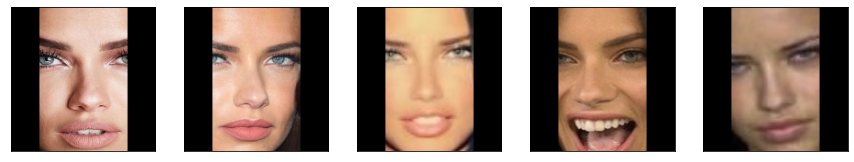

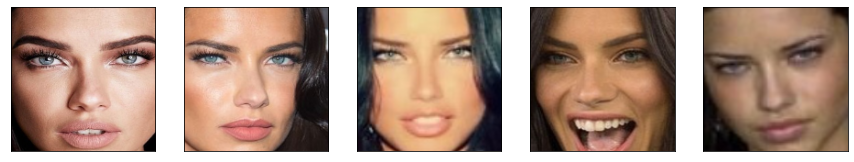

In [8]:
plot(create_masked_images(images[0: 5], percent_mask = 0.4, hide_axis=2)[0], figsize=(15, 15))
plot(images[0: 5], figsize=(15, 15))

In [9]:
# Initially 60% image is masked, 530 for training and 100 for testing.
# Reduce masking size if network doesnt optimize

In [10]:
masked_images, mask = create_masked_images(images, percent_mask = 0.4, hide_axis=2)

In [11]:
masked_images.shape, mask.shape

((630, 158, 158, 3), (158, 158, 3))

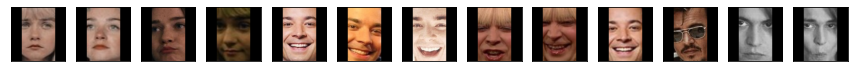

In [12]:
start, end = 290, 303
plot(masked_images[start: end], figsize=(15, 15))

In [13]:
# https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

def image_generator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(64, (5, 5), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(4, 4), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(8, 8), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    return Model(input_img, x, name='Generator')


def image_discriminator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(input_img)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input_img, x, name='Discriminator')


    

In [14]:
gen_model = image_generator((158, 158, 3))
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 158, 158, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 158, 158, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 79, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 79, 79, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 79, 79, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 79, 79, 256)       59

In [15]:
disc_model = image_discriminator(image_shape=(158, 158, 3))
disc_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 158, 158, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 79, 79, 32)        2432      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        102464    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)        102464    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 64)          102464    
_________________________________________________________________
flatten (Flatten)            (None, 1600)            

In [16]:
# Loss functions

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def cosine_sim(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))))

# y_true is the output of the discriminator for actual images
# y_pred is the output of the discriminator for generator generated images

def discriminator_loss(y_true, y_pred, epsilon=1e-7):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, epsilon)) + tf.math.log(tf.maximum(1-y_pred, epsilon)))


# y_true is the actual image
# y_pred is the Generator generated image
# discriminator_pred is the output of the discriminator when given image generated by the generator
# alpha is used as a control variable to determine the importance of mse loss
def generator_loss(y_true, y_pred, discriminator_pred, mask_compliment, alpha=0.0004, epsilon=1e-7):
    return mse(y_true, y_pred) - alpha*tf.reduce_mean(tf.math.log(tf.maximum(discriminator_pred, epsilon)))


#Tensorflow function to find psnr and rmse of an image
def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))



In [17]:
def save_models(generator, discriminator, gen_filename='', disc_filename=''):

    save_model(generator, gen_filename)
    save_model(discriminator, disc_filename)


# To save the new logs
def save_logs(logs, previous_logs=None, logfile_name='', keys=None):

    temp = {}
    if previous_logs and keys:

        for key in keys:
            temp[key] = previous_logs[key] + logs[key]
    
    else:
        temp = logs
    
    with open(logfile_name, 'wb') as file:
        pickle.dump(temp, file)
    
    return True
        
# Load the logfile
def load_logs(logfile_name=None):

    if logfile_name:
        try:
            with open(logfile_name, 'rb') as file:
                temp_logs = pickle.load(file)

            print("Log file loaded in the form of a dictionary")

            return temp_logs

        except FileNotFoundError:
            print("No log file created, Returned an empty dictionary")
            return {}
            
    return False

In [18]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
# pass pre compiled generator and discriminator models as input to the function

# kwargs can contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function),
#                    optimizer = (gen_optimizer, disc_optimizer)
#                    mask_compliment, accuracy_function,
#                    save_after, save_model

def train(gen_model, disc_model, **kwargs):

    test_present = True if 'test_data' in kwargs else False

    if 'train_data' in kwargs:
        masked_images, actual_images = kwargs['train_data'][0], kwargs['train_data'][1]

    if 'test_data' in kwargs:
        masked_test, actual_test = kwargs['test_data'][0], kwargs['test_data'][1]  

    # Default epoch count
    epochs, epochs_done = 100, 0
    if 'epochs' in kwargs:
        total_epochs, phase_1, phase_2  = kwargs['epochs']
        epochs_done = kwargs['epochs_done']
    
    # Default batch_size value
    batch_size = 32
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']

    if 'loss' in kwargs:
        gen_loss_function, disc_loss_function = kwargs['loss'][0], kwargs['loss'][1]

    if 'optimizer' in kwargs:
        gen_optimizer, disc_optimizer = kwargs['optimizer'][0], kwargs['optimizer'][1]
    
    if 'mask_compliment' in kwargs:
        mask_compliment = kwargs['mask_compliment']
    
    if 'metric' in kwargs:
        accuracy = kwargs['metric']

    if 'mse' in kwargs:
        mse_error = kwargs['mse']
    
    save_after = 10
    if 'save_after' and 'save_models' in kwargs:
        save_after = kwargs['save_after']
        save = kwargs['save_models']
        
    if 'history' and 'save_logs' in kwargs:
        history = kwargs['history']
        save_logs = kwargs['save_logs']
        

    # List to store the loss and accuracy values after each epochs
    global gen_losses, disc_losses, test_gen_losses, test_disc_losses
    global gen_accuracy, test_gen_accuracy
    global temp_history

    gen_losses, disc_losses, gen_accuracy, temp_history = [], [], [], {}
    test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    
    # Train for desired number of epochs
    for step in range(total_epochs-epochs_done):
        
        # Shuffle the dataset at the start of each epoch
        masked_images, actual_images = shuffle(masked_images, actual_images)

        # Print which phase is the training going on
        if epochs_done + step == 0:
            print("----------------Starting Phase 1----------------")
        elif epochs_done + step == phase_1:
            print("----------------Starting Phase 2----------------")
        elif epochs_done + step == phase_1 + phase_2:
            print("----------------Starting Phase 3----------------")

        print(f'Epoch {epochs_done+step+1}/{total_epochs}', end='\n[')
        start_time = time.time()

        # Generator & Discriminator Loss and accuracy trackers for each epochs
        gen_loss, gen_acc = 0, 0
        disc_loss = 0

        # Loss alters after phase 1, so variable to change the name of the loss 
        gen_loss_name = 'MSE'
        if epochs_done + step >= phase_1:
            gen_loss_name = 'altered_MSE'

            
        # train on batch data
        batch_steps = masked_images.shape[0]//batch_size
        for batch_step in range(batch_steps):
            
            # Generator & Discriminator Loss and accuracy trackers for each batch
            gen_batch_loss, disc_batch_loss = 0, 0
            gen_batch_acc = 0
            start, end = batch_step*batch_size, (batch_step+1)*batch_size
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                # Generator applied to masked images
                gen_train = gen_model(masked_images[start: end], training=True)
                
                # Discriminator makes prediction on both masked and actual images
                y_pred = disc_model(gen_train, training=True)
                y_true = disc_model(actual_images[start: end], training=True)
                
                # Uncomment these lines if binary crossentropy loss is to be used
                # y_true = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
                # y_pred = tf.concat([y_pred, y_true], axis=0)

                # Generator accuracy
                gen_batch_acc = accuracy(actual_images[start: end], gen_train)

                # Phase 1: Compute Loss for both Generator and Discriminator
                if epochs_done + step < phase_1:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))
                
                # Phase 2: Compute loss for both Generator and Discriminator
                elif epochs_done + step < phase_1 + phase_2:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Phase 3: Computer altered loss for Generator and loss for Discriminator
                else:
                    # Find out loss for phase 3
                    gen_batch_loss = gen_loss_function(actual_images[start: end], gen_train, y_pred, mask_compliment)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Add batch loss to the epoch loss
                gen_loss += gen_batch_loss
                disc_loss += disc_batch_loss    
                gen_acc += gen_batch_acc
            

            # Phase 1: Train only Generator on MSE loss
            if epochs_done + step < phase_1:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))

            # Phase 2: Train only Discriminator
            elif epochs_done + step < phase_1 + phase_2:
                disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
            
            # Phase 3: Train both Generator and Discriminator, Generator -> Altered_MSE losss
            else:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))
                

                if 'train_disc_after' in kwargs:
                    if batch_step % kwargs['train_disc_after'] == 0:
                        disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                        disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                
                else:
                    disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                    

            if batch_step % 5 == 0:
                print('=', end='')
        
        print(']', end='  ')
        # Add mean of batch_losses into loss_list
        gen_losses.append(gen_loss/batch_steps)
        disc_losses.append(disc_loss/batch_steps)

        # Add mean of batch accuracy into accuracy list
        gen_accuracy.append(gen_acc/batch_steps)

        # Calculate the time elapsed for the total epoch
        elapsed_time = time.time() - start_time
        
        # Validation dataset
        if 'test_data' in kwargs:
            test_gen_pred = gen_model(masked_test)
            
            test_pred = disc_model(test_gen_pred)
            test_true = disc_model(actual_test)
            
            # Uncomment if binary crossentropy loss is to be used
            # zeros, ones = tf.zeros((masked_test.shape[0], 1)), tf.ones((actual_test.shape[0], 1))
            # test_true, test_pred = tf.concat([zeros, ones], axis=0), tf.concat([test_pred, test_true], axis=0)

            test_psnr = accuracy_function(actual_test, test_gen_pred)

            # Compute Test loss for Generator
            if epochs_done + step < phase_1 + phase_2:
                test_gen_loss = mse_error(actual_test, test_gen_pred)
            else:
                test_gen_loss = gen_loss_function(actual_test, test_gen_pred, test_pred, mask_compliment)

            # Compute Test loss for Discriminator
            test_disc_loss = tf.reduce_mean(disc_loss_function(test_true, test_pred))

            # Append losses to the loss list
            test_gen_losses.append(test_gen_loss)
            test_disc_losses.append(test_disc_loss)
            test_gen_accuracy.append(test_psnr)
            
            # print Metrics
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}, Test {gen_loss_name} = {test_gen_loss:.4f}, Test Disc Loss = {test_disc_loss:.4f}, Test PSNR = {test_psnr:.3f} ')    

        else:
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}')

        print(f'Time per epoch: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        print()

        # save the models and the log files
        if step % save_after == 0 or epochs_done + step == total_epochs-1:

            save_model(gen_model, f'Generator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            save_model(disc_model, f'Discriminator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            
            # save(gen_model, disc_model,
            #      gen_filename=f'Generator_{step+1+epochs_done}epochs.h5', 
            #      disc_filename=f'Discriminator_{step+1+epochs_done}epochs.h5')

            if 'history' in kwargs:
                
                # If there are no keys in the logfile
                if history == {}:
                    keys = ['generator_losses', 'disc_losses', 'psnr']
                    
                    if test_present:
                        keys.append('test_generator_losses')
                        keys.append('test_discriminator_losses')
                        keys.append('test_psnr')
                
                else:
                    keys = history.keys()

                if test_present:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy,
                                    'test_generator_loss':test_gen_losses, 'test_discriminator_loss':test_disc_losses, 'test_psnr':test_gen_accuracy},
                            previous_logs=history,
                            logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                            keys=keys)

                else:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy},
                              previous_logs=history,
                              logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                              keys=keys)

                    
                # Update current logs
                history = load_logs(logfile_name=f'logs_{step+1+epochs_done}epochs.pickle')

                # Display the first 4 examples and its metrics
                if 'plot_function' in kwargs:

                    print("Test Images")
                    kwargs['plot_function'](np.array(test_gen_pred[: 4]), figsize=(15, 15))
                    
                    print("Masked Images")
                    kwargs['plot_function'](np.array(masked_test[: 4]), figsize=(15, 15))

                    print("Actual Images")
                    kwargs['plot_function'](np.array(actual_test[: 4]), figsize=(15, 15))

                    print(f"PSNR: {psnr(actual_test[: 4], test_gen_pred[: 4])}")
                    print(f"MSE: {mse(actual_test[: 4], test_gen_pred[: 4])}")
                    print(f'RMSE: {rmse(actual_test[: 4], test_gen_pred[: 4])}')
                    print(f'Cosine Similarity: {cosine_sim(actual_test[: 4], test_gen_pred[: 4])}')
                    print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(test_gen_pred[: 4]))}')
                    print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(actual_test[: 4]))}')


            # Reset the losses as they are being saved to avoid repeatation
            gen_losses, disc_losses, gen_accuracy = [], [], []
            test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    
    

In [19]:
# Common parameters for generator and discriminator

# metrics = [tf.metrics.RootMeanSquaredError]
batch_size = 16
lr_rate = 0.001
epochs = (100, 7, 5)
epochs_done = 191
epsilon = 1e-7
save_after = 10
train_disc_after = 4


# Comment the lr_schedule, gen_optimizer and disc_optimizer if model is to be reloaded
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
#                                                              decay_steps=10000, 
#                                                              decay_rate=0.96,
#                                                              staircase=True)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.5, beta_2=0.999, epsilon=epsilon)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.5, beta_2=0.999, epsilon=epsilon)

gen_loss = generator_loss
disc_loss = discriminator_loss
mse_error = mse

train_data = (masked_images[: 600], images[: 600])
test_data = (masked_images[600: 630], images[600: 630])
loss = (gen_loss, disc_loss)
mask_compliment = 1 - mask
accuracy_function = psnr

logs = load_logs(logfile_name='/logs_191epochs.pickle')
print("Keys in Dictionary: ", logs.keys())
try:
    print("Length: ", len(logs['generator_loss']))
except KeyError:
    pass

Log file loaded in the form of a dictionary
Keys in Dictionary:  dict_keys(['generator_loss', 'discriminator_loss', 'psnr', 'test_generator_loss', 'test_discriminator_loss', 'test_psnr'])
Length:  183


In [ ]:
epochs_done = 10

In [ ]:
# Run this cell only if the model is to be trained from the beginning
gen_model.compile(optimizer=gen_optimizer, loss=gen_loss)
disc_model.compile(optimizer=disc_optimizer, loss=disc_loss)

In [20]:
gen_model = load_model('/Generator_191epochs.h5', custom_objects={'generator_loss': gen_loss})
disc_model = load_model('/Discriminator_191epochs.h5', custom_objects={'discriminator_loss':disc_loss})

gen_optimizer = gen_model.optimizer
disc_optimizer = disc_model.optimizer

Epoch 192/200
[========]  altered_MSE = 0.0059, Disc Loss = 0.9287, PSNR = 23.321, Test altered_MSE = 0.0184, Test Disc Loss = 2.6647, Test PSNR = 18.594 
Time per epoch: 00:03:39



Log file loaded in the form of a dictionary
Test Images


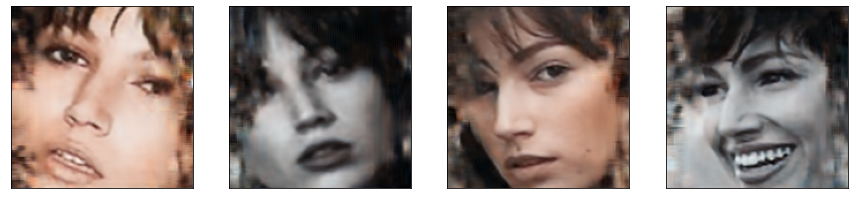

Masked Images


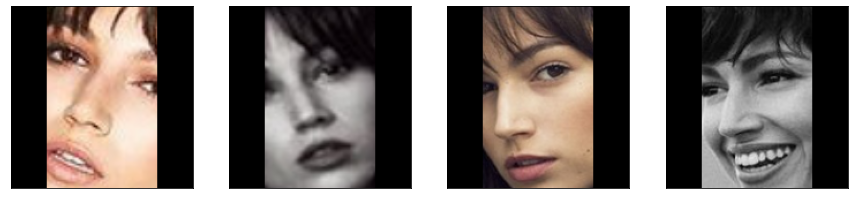

Actual Images


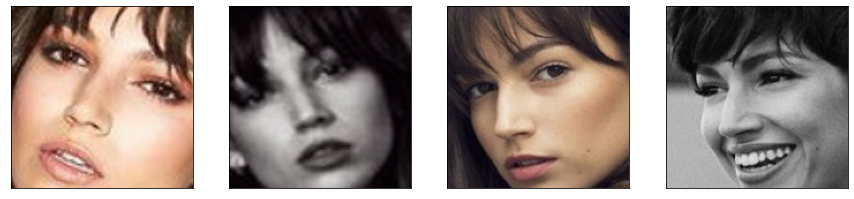

PSNR: 19.673295974731445
MSE: 0.010961986146867275
RMSE: 0.10469950735569
Cosine Similarity: 0.9915605187416077
Discriminator Prediction on Generator: 0.004969288129359484
Discriminator Prediction on Actual: 0.11303777992725372
Epoch 193/200
[========]  altered_MSE = 0.0052, Disc Loss = 0.9533, PSNR = 23.866, Test altered_MSE = 0.0173, Test Disc Loss = 2.4656, Test PSNR = 18.853 
Time per epoch: 00:03:39

Epoch 194/200
[========]  altered_MSE = 0.0049, Disc Loss = 0.9699, PSNR = 24.046, Test altered_MSE = 0.0176, Test Disc Loss = 3.0578, Test PSNR = 18.899 
Time per epoch: 00:03:40

Epoch 195/200
[========]  altered_MSE = 0.0051, Disc Loss = 0.9780, PSNR = 23.837, Test altered_MSE = 0.0185, Test Disc Loss = 2.5606, Test PSNR = 18.639 
Time per epoch: 00:03:40

Epoch 196/200
[========]  altered_MSE = 0.0051, Disc Loss = 0.9382, PSNR = 23.928, Test altered_MSE = 0.0179, Test Disc Loss = 2.4005, Test PSNR = 18.652 
Time per epoch: 00:03:40

Epoch 197/200
[========]  altered_MSE = 0.0052, 

Log file loaded in the form of a dictionary
Test Images


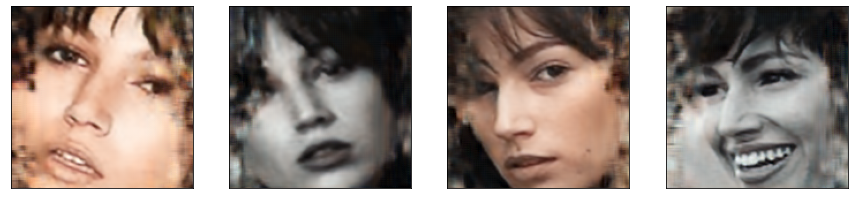

Masked Images


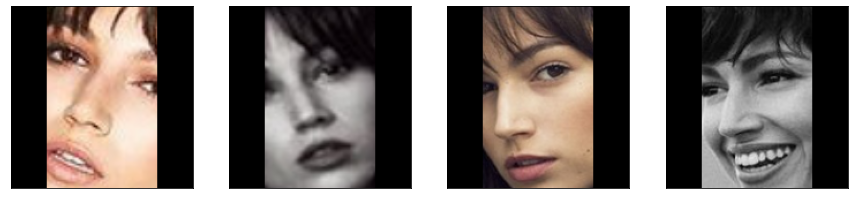

Actual Images


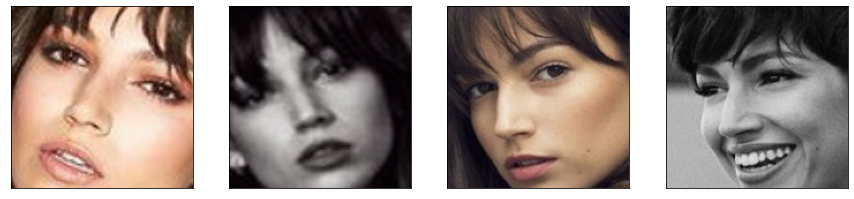

PSNR: 20.084720611572266
MSE: 0.009975786320865154
RMSE: 0.09987886250019073
Cosine Similarity: 0.9923438429832458
Discriminator Prediction on Generator: 0.0023994669318199158
Discriminator Prediction on Actual: 0.0991751179099083


In [25]:
# kwargs contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function), 
#                    optimizer = (optimizer, optimizer),
#                    mask_compliment, accuracy_function,
#                    save_after, checkpoint_function,

train(gen_model, disc_model, 
      train_data=train_data,
      test_data = test_data,
      epochs=epochs, epochs_done=epochs_done, 
      train_disc_after=train_disc_after,
      batch_size=batch_size, 
      loss=(gen_loss, disc_loss), mse = mse_error,
      optimizer=(gen_optimizer, disc_optimizer), 
      mask_compliment=mask_compliment, 
      metric=accuracy_function,
      save_after=save_after, save_models=save_models,
      history=logs, save_logs=save_logs,
      plot_function=plot)

In [26]:
# Run this cell only if the above cell is interrupted or threw some error
# Load the logs of the completely trained model
logs = load_logs(logfile_name='/content/logs_200epochs.pickle')

Log file loaded in the form of a dictionary


Generated Images


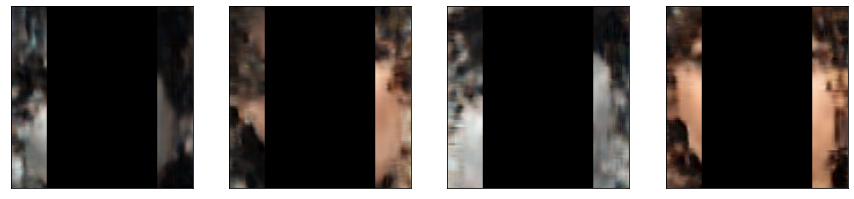

Masked Images


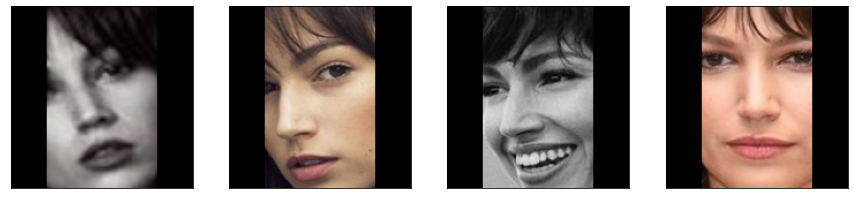

Actual Clear Images


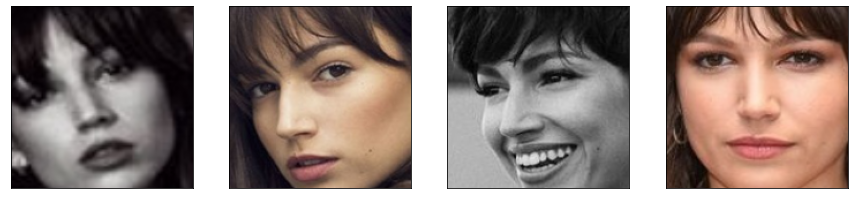

PSNR: 20.44054412841797
MSE: 0.009045146405696869
RMSE: 0.09510597339751074
Cosine Similarity: 0.9918221235275269
Discriminator Prediction on Generator: 0.0024193227291107178
Discriminator Prediction on Actual: 0.10056562721729279

Masked PSNR: 20.662246704101562
Masked mse: 0.009045146405696869
Masked RMSE: 0.09510597339751074
Masked Cosine Similarity: 0.9918221235275269


In [35]:
# 0.0327
# start = np.random.randint(600, 626)
start = np.random.randint(600, 626)
count = 4
end = start + count
figsize = (15, 15)
percent_mask = 0.4

validation_dataset, validate_mask = create_masked_images(images[start: end], percent_mask = percent_mask, hide_axis=2)

gen_imgs = gen_model.predict(validation_dataset)

print("Generated Images")
plot((1-validate_mask)*gen_imgs, figsize=figsize)

print("Masked Images")
plot(validation_dataset, figsize=figsize)

print("Actual Clear Images")
plot(images[start: end], figsize=figsize)

print(f"PSNR: {psnr(images[start: end], gen_imgs)}")
print(f"MSE: {mse(images[start: end], gen_imgs)}")
print(f'RMSE: {rmse(images[start: end], gen_imgs)}')
print(f'Cosine Similarity: {cosine_sim(images[start: end], gen_imgs)}')
print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(gen_imgs))}')
print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(images[start: end]))}')

print()

# Metrics on masked images
print(f"Masked PSNR: {psnr((1-validate_mask)*images[start: end], (1-validate_mask)*gen_imgs)}")
print(f"Masked mse: {mse(images[start: end], gen_imgs)}")
print(f'Masked RMSE: {rmse(images[start: end], gen_imgs)}')
print(f'Masked Cosine Similarity: {cosine_sim(images[start: end], gen_imgs)}')

In [21]:
def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_data, label=f'Train {name}')
    
    if validation_data:
        plt.plot(validation_data, label=f'Test {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

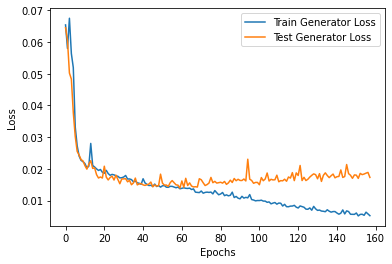

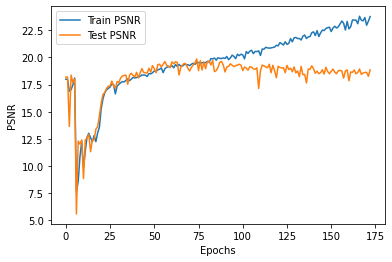

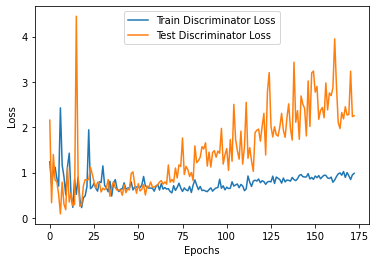

In [24]:
# First 10 epoch data not shown because of higher values of loss and lower valus PSNR initially

plot_curve(logs['generator_loss'][25: ], logs['test_generator_loss'][25: ], name='Generator Loss', xlabel='Epochs', ylabel='Loss')
plot_curve(logs['psnr'][10: ], logs['test_psnr'][10: ], name='PSNR', xlabel='Epochs', ylabel='PSNR')
plot_curve(logs['discriminator_loss'][10: ], logs['test_discriminator_loss'][10: ], name='Discriminator Loss', xlabel='Epochs', ylabel='Loss')

In [ ]:
load_model('/Generator_100epochs.h5', custom_objects={'generator_loss':gen_loss})

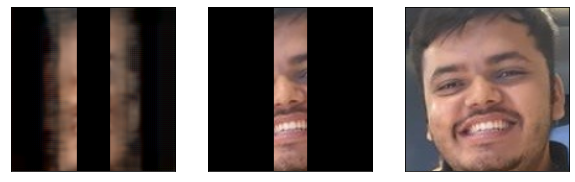

PSNR: 10.439781188964844
MSE: 0.09036948531866074
RMSE: 0.3006151729471878
Cosine Similarity: 0.8081144690513611

Discriminator Prediction on Generator: 0.9252352714538574
Discriminator Prediction on Actual: 0.7085595726966858



In [ ]:
test_img = cv2.imread('/profile_pic.jpg')
test_img = cv2.cvtColor(cv2.resize(test_img, (224, 224)), cv2.COLOR_BGR2RGB)
test_img = np.reshape(test_img/255, (1, 224, 224, 3))

test_img = test_img[:, 31: 189, 31: 189, :]

test_masked, test_mask = create_masked_images(test_img, percent_mask = 0.8, hide_axis=2)

test_figsize = (10, 10)
gen_test = gen_model.predict(test_masked)

plot([(1-test_mask)*gen_test[0], test_masked[0], test_img[0]], figsize=test_figsize)


print(f"PSNR: {psnr(test_img, gen_test)}")
print(f"MSE: {mse(test_img, gen_test)}")
print(f'RMSE: {rmse(test_img, gen_test)}')
print(f'Cosine Similarity: {cosine_sim(test_img, gen_test)}')

print()
print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(gen_test))}')
print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(test_img))}')

print()

In [23]:
save_model(gen_model, f'Generator_200epochs.h5', include_optimizer=True, save_format='h5')
save_model(disc_model, f'Discriminator_200epochs.h5', include_optimizer=True, save_format='h5')